In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('metal.csv', index_col=['date'])
prices.head(10)

TATASTEEL.NS  HINDALCO.NS  JSWSTEEL.NS  ADANIENT.NS     VEDL.NS  \
date                                                                          
01-01-2018    688.066406   271.149994   265.799988    90.480850  325.450012   
02-01-2018    694.830810   271.899994   264.549988    89.309311  327.750000   
03-01-2018    700.213806   276.500000   268.700012    96.011597  332.500000   
04-01-2018    724.318054   279.799988   277.149994    99.880394  339.100006   
05-01-2018    734.274109   276.399994   285.100006   105.247673  339.549988   
08-01-2018    732.416321   276.149994   286.000000   107.045845  340.250000   
09-01-2018    735.798523   271.500000   284.000000   106.746147  337.700012   
10-01-2018    736.322510   268.799988   282.799988   108.326363  334.799988   
11-01-2018    734.512329   267.750000   282.549988   109.906578  333.899994   
12-01-2018    733.845398   268.850006   286.799988   108.953003  339.549988   

            COALINDIA.NS    SAIL.NS  JINDALSTEL.NS     NMDC.NS  APLAPOLLO.NS  
date                                                                          
01-01-2018    266.649994  92.699997     206.199997  141.050003    198.059998  
02-01-2018    270.049988  91.849998     203.399994  148.600006    198.014999  
03-01-2018    271.850006  93.800003     219.550003  149.250000    211.110001  
04-01-2018    277.799988  97.900002     244.550003  154.750000    229.990005  
05-01-2018    278.750000  97.400002     239.050003  158.550003    228.979996  
08-01-2018    287.450012  98.800003     256.450012  161.850006    228.110001  
09-01-2018    304.049988  97.949997     248.750000  154.699997    224.845001  
10-01-2018    308.299988  98.449997     262.399994  155.300003    221.845001  
11-01-2018    308.100006  98.500000     267.350006  155.350006    218.059998  
12-01-2018    309.000000  98.650002     264.850006  154.949997    222.729996

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

TATASTEEL.NS  HINDALCO.NS  JSWSTEEL.NS  ADANIENT.NS     VEDL.NS  \
date                                                                          
01-01-2018    688.066406   271.149994   265.799988    90.480850  325.450012   
02-01-2018    694.830810   271.899994   264.549988    89.309311  327.750000   
30-12-2020    640.450012   237.399994   386.100006   484.149994  162.050003   
31-12-2020    643.650024   240.550003   387.200012   479.549988  161.399994   

            COALINDIA.NS    SAIL.NS  JINDALSTEL.NS     NMDC.NS  APLAPOLLO.NS  
date                                                                          
01-01-2018    266.649994  92.699997     206.199997  141.050003    198.059998  
02-01-2018    270.049988  91.849998     203.399994  148.600006    198.014999  
30-12-2020    135.600006  69.750000     265.950012  115.900002    417.674988  
31-12-2020    135.449997  74.099998     266.450012  114.449997    441.500000

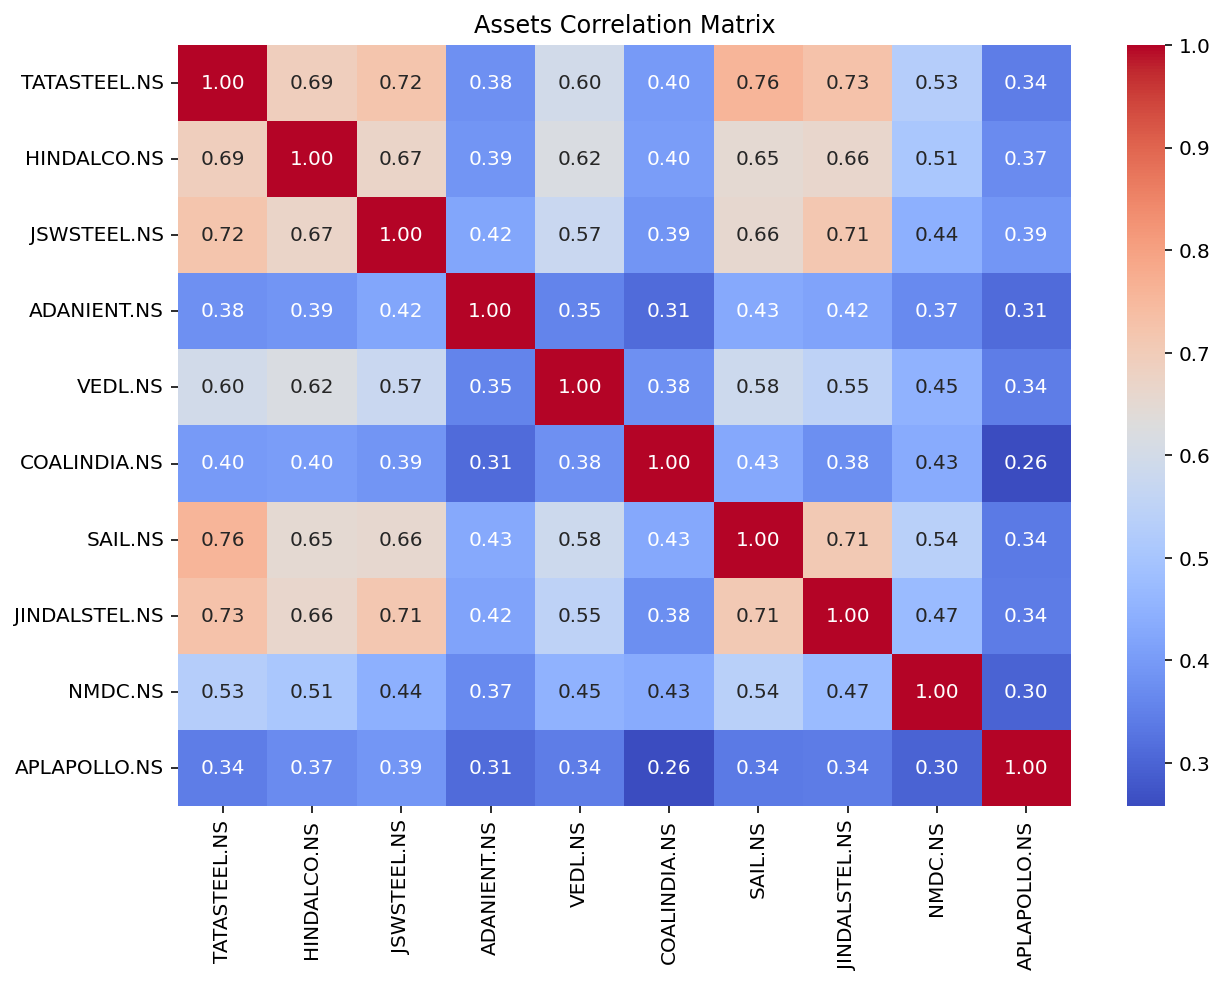

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('TATASTEEL.NS', 'JSWSTEEL.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS')]


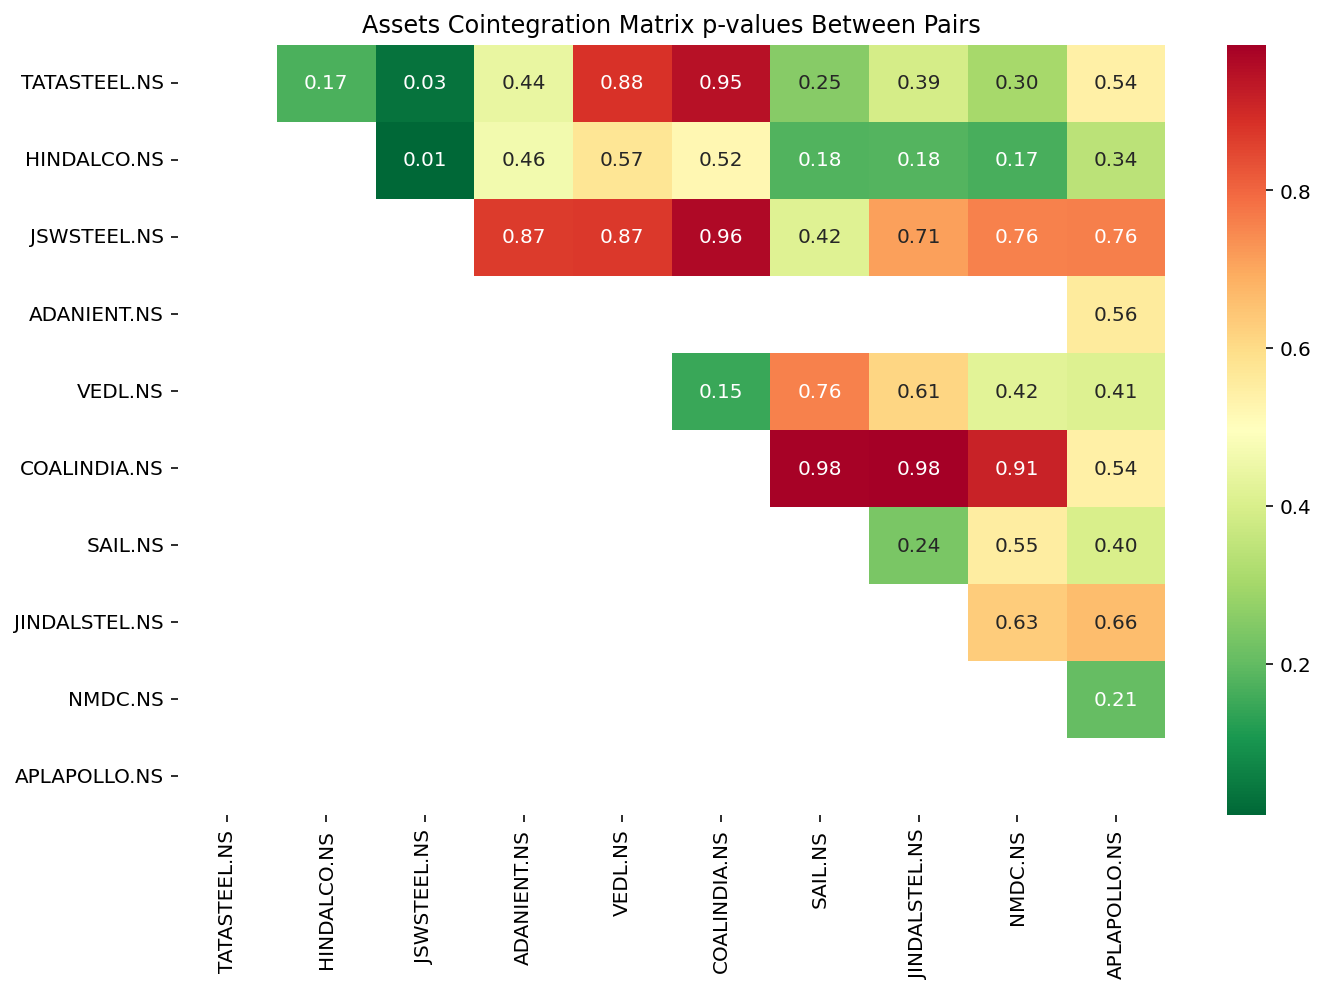

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'HINDALCO.NS'
asset2 = 'NMDC.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

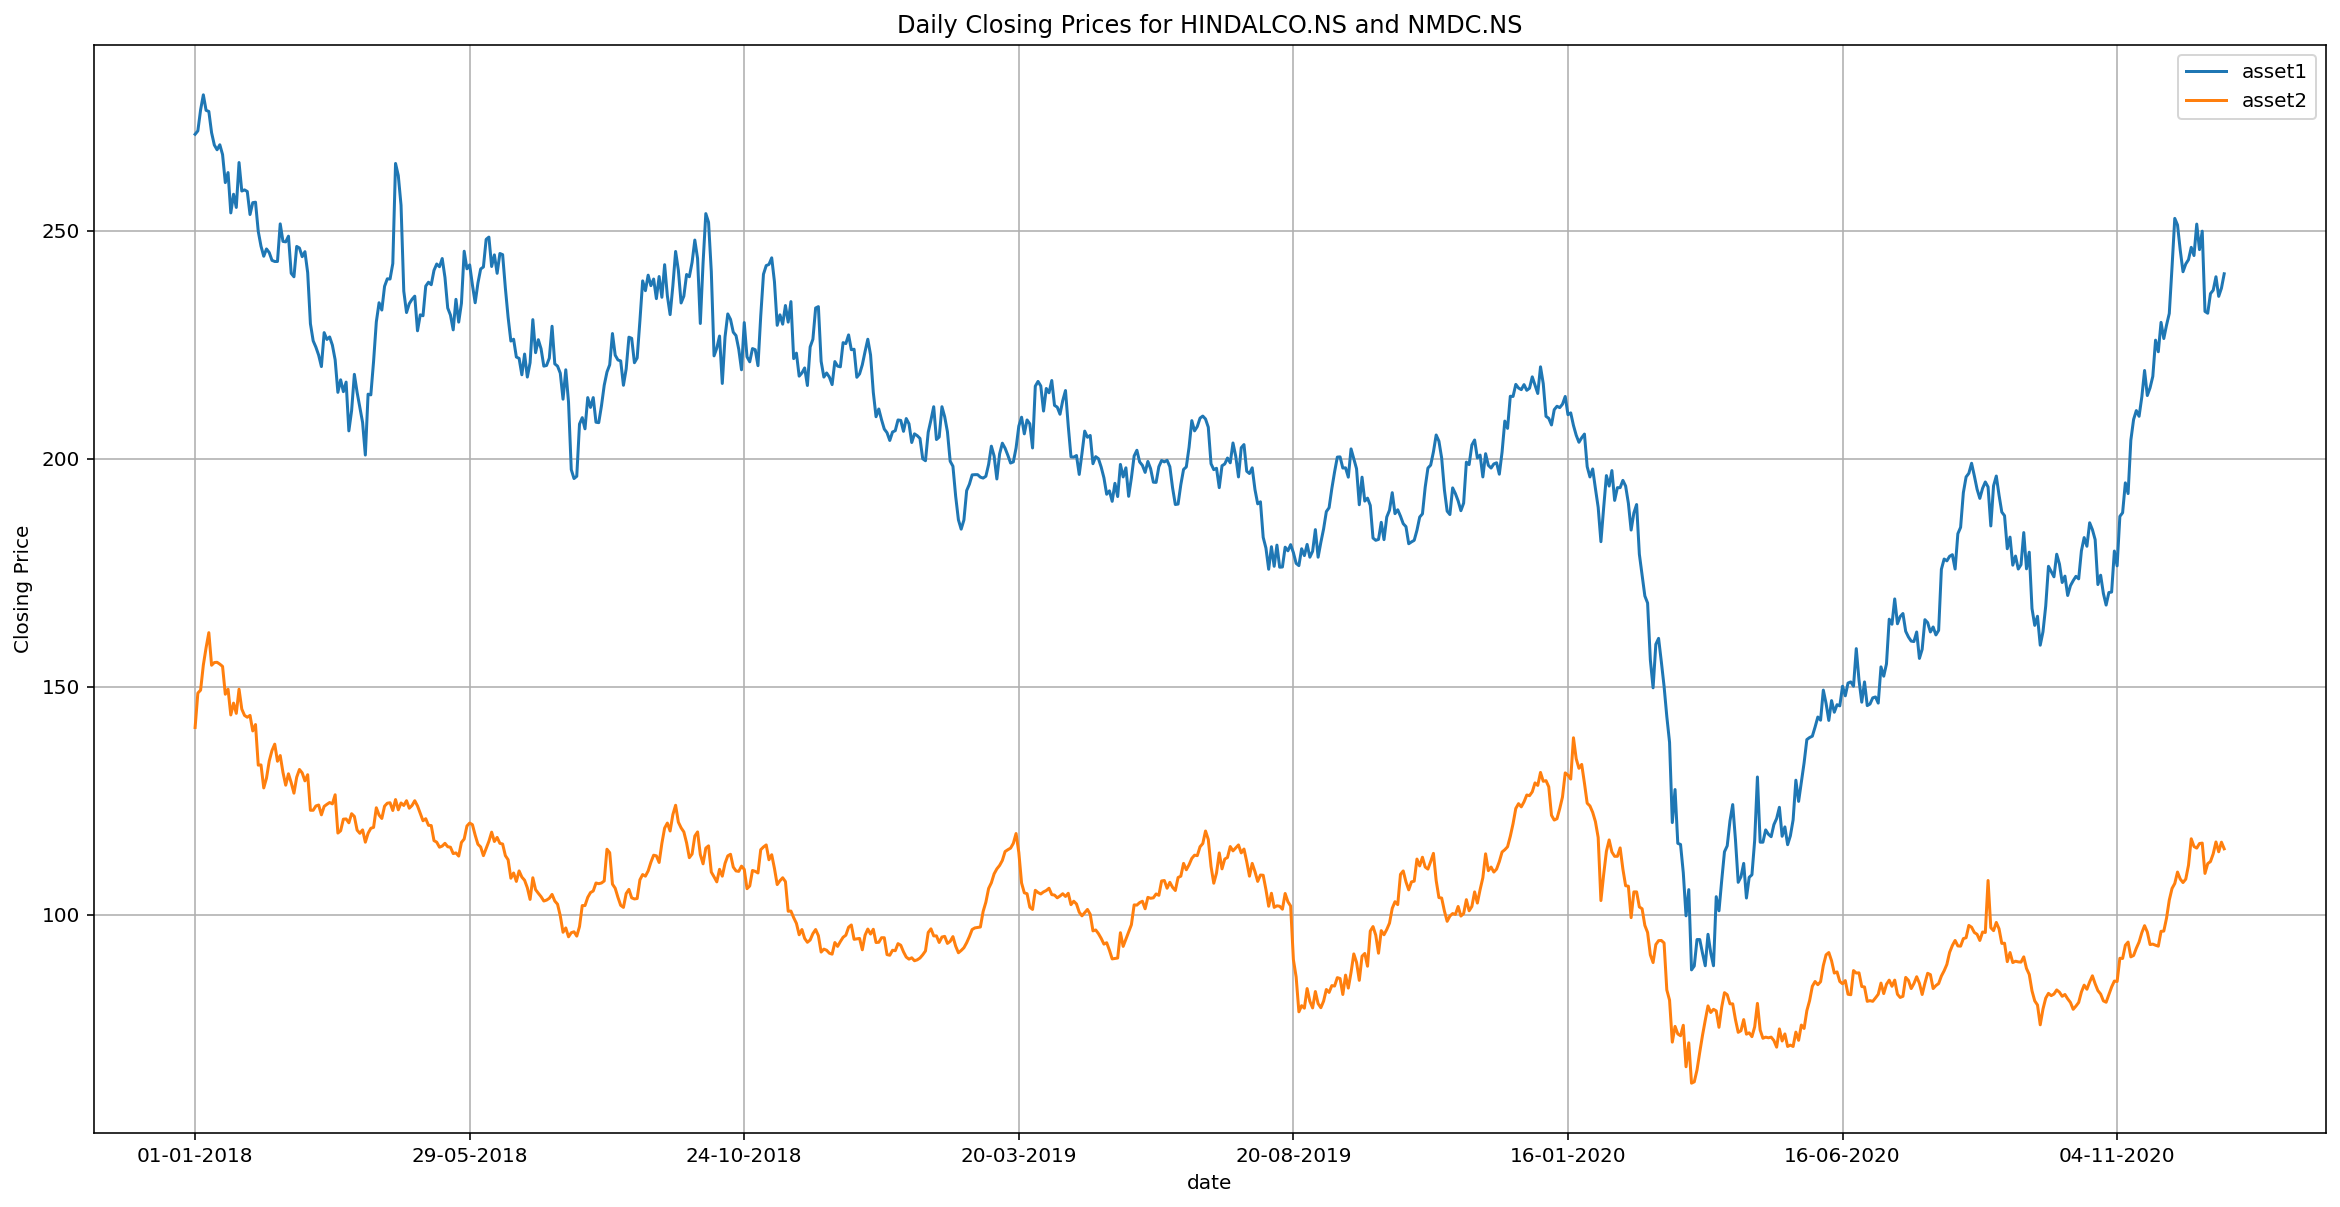

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          6.274e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        00:49:08   Log-Likelihood:                         -2843.0
No. Observations:                 740   AIC:                                      5688.
Df Residuals:                     739   BIC:                                      5693.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.5104      0.002    250.483      0.000       0.506       0.514
==============================================================================
Omnibus:                       28.095   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.203
Skew:                           0.200   Prob(JB):                     0.000303
Kurtosis:                       2.395   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

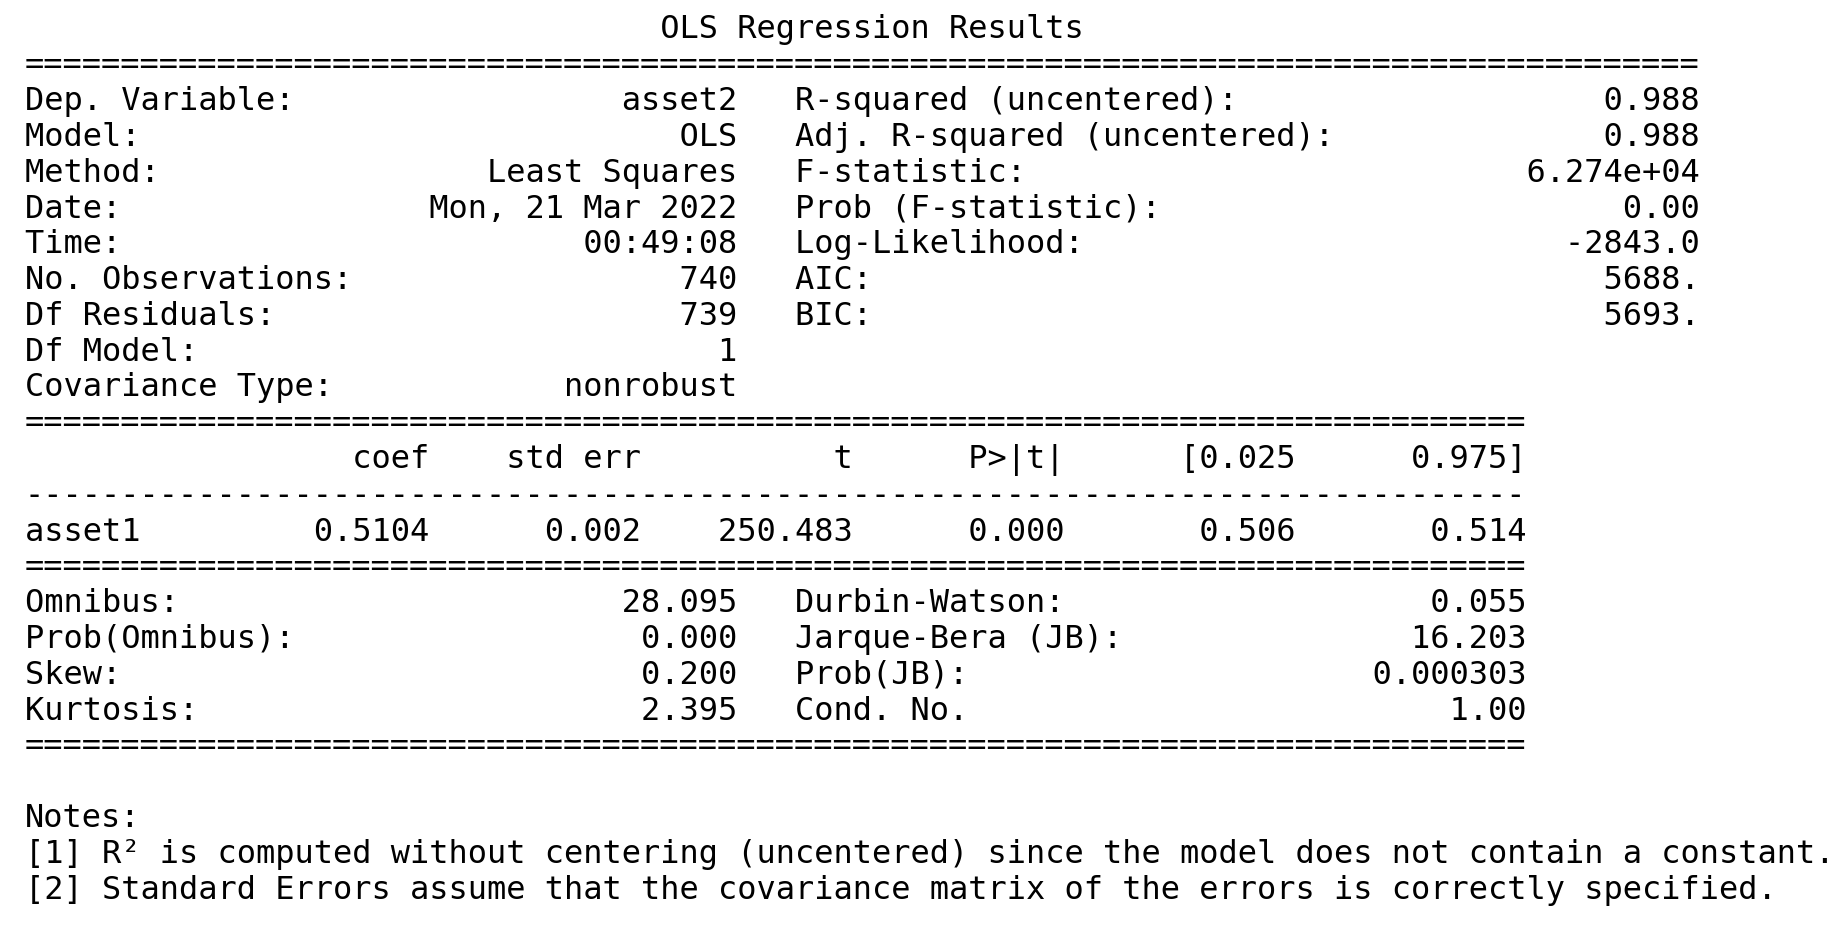

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.510449936593577


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

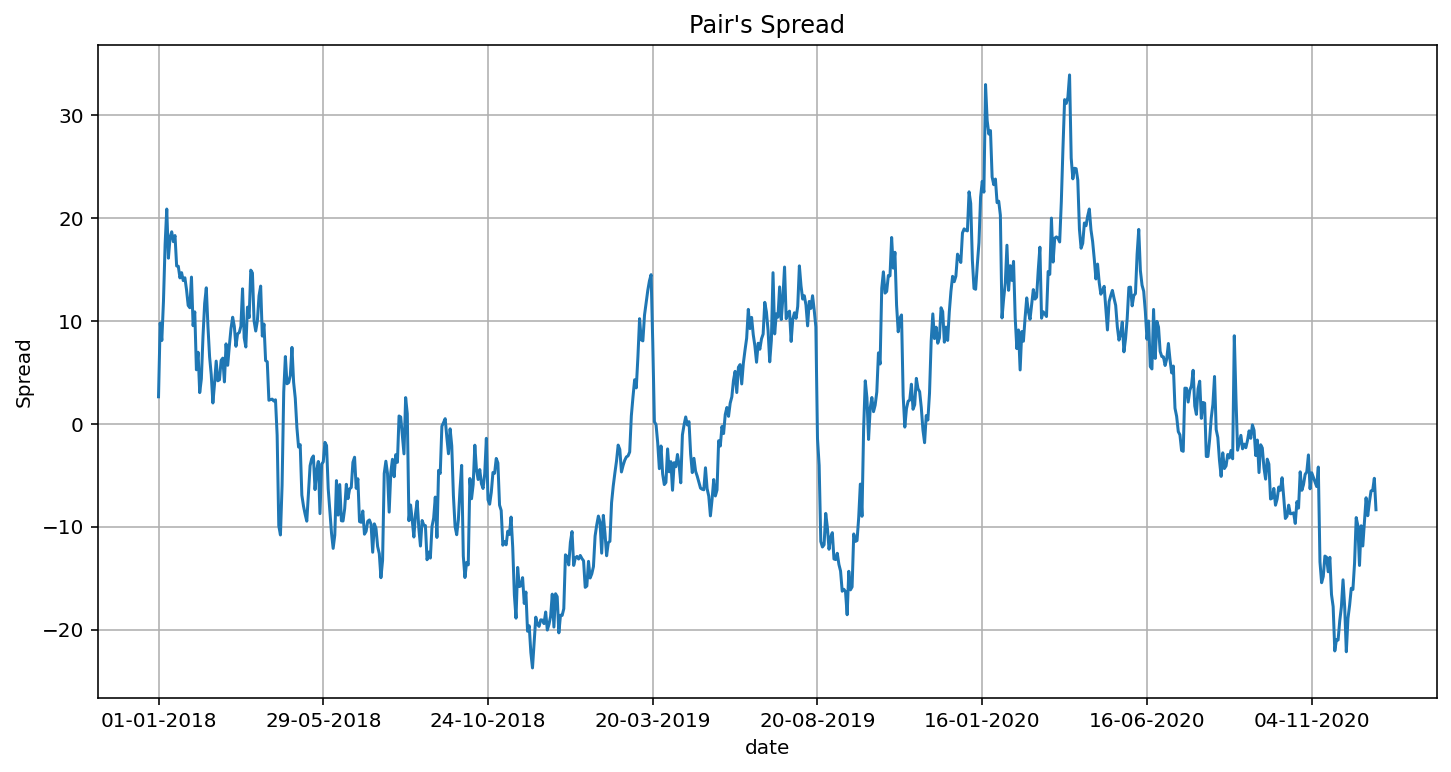

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.1772075754781444,
 0.021342485247699584,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 3524.017287573226)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.1772075754781444


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  238.350006  116.349998
04-01-2021  254.300003  122.400002
05-01-2021  250.300003  120.949997
06-01-2021  259.049988  123.250000
07-01-2021  272.899994  127.949997

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  238.350006  116.349998 -1.286999            1.0           -1.0
04-01-2021  254.300003  122.400002 -1.225710            1.0           -1.0
05-01-2021  250.300003  120.949997 -1.242932            1.0           -1.0
06-01-2021  259.049988  123.250000 -1.174638            1.0           -1.0
07-01-2021  272.899994  127.949997 -1.109162            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

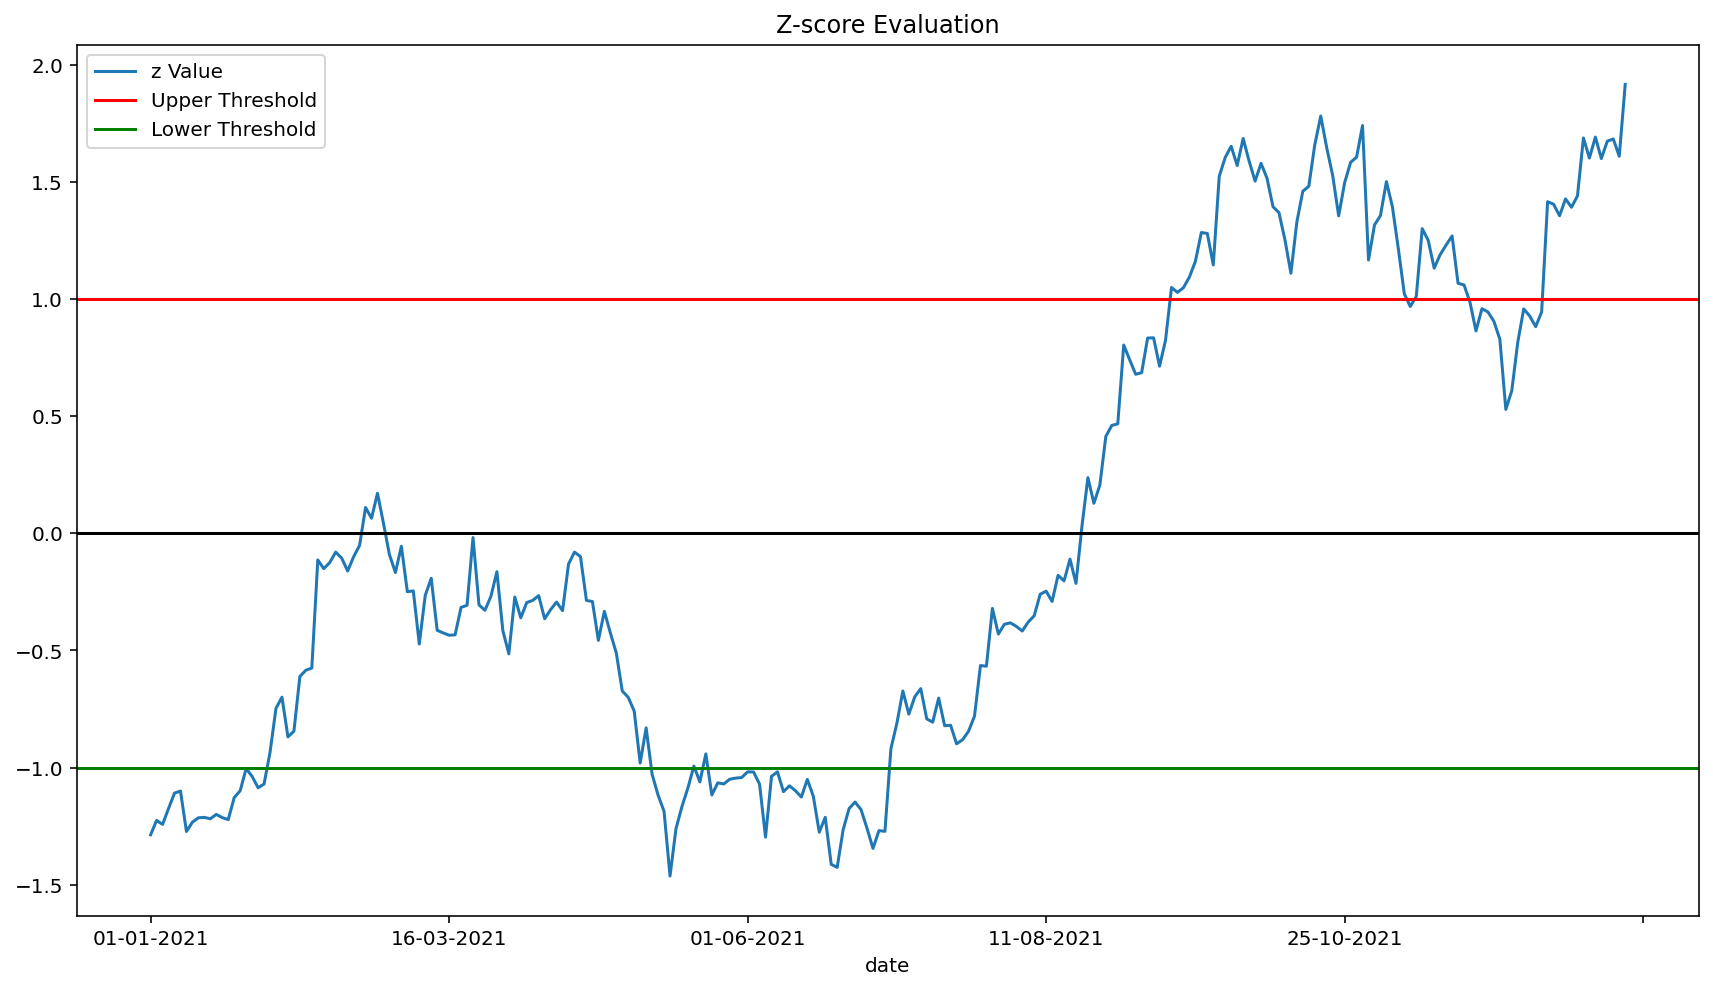

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  116.349998 -1.286999            1.0           -1.0   
04-01-2021  254.300003  122.400002 -1.225710            1.0           -1.0   
05-01-2021  250.300003  120.949997 -1.242932            1.0           -1.0   
29-12-2021  454.250000  131.399994  1.684066            1.0           -1.0   
30-12-2021  449.649994  131.399994  1.610218            1.0           -1.0   
31-12-2021  475.549988  133.300003  1.917194            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  116.349998 -1.286999            1.0           -1.0   
04-01-2021  254.300003  122.400002 -1.225710            1.0           -1.0   
05-01-2021  250.300003  120.949997 -1.242932            1.0           -1.0   
06-01-2021  259.049988  123.250000 -1.174638            1.0           -1.0   
07-01-2021  272.899994  127.949997 -1.109162            1.0           -1.0   
08-01-2021  268.200012  125.500000 -1.100329            1.0           -1.0   
11-01-2021  264.700012  128.800003 -1.273153            1.0           -1.0   
12-01-2021  264.350006  127.449997 -1.233025            1.0           -1.0   
13-01-2021  262.649994  126.099998 -1.214622            1.0           -1.0   
14-01-2021  261.399994  125.449997 -1.212876            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
13-01-2021         1         0.0        -1         0.0  
14-01-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  116.349998 -1.286999            1.0           -1.0   
01-02-2021  241.149994  108.849998 -0.934984            1.0           -1.0   
07-05-2021  401.100006  184.750000 -1.028628            1.0           -1.0   
19-05-2021  403.299988  184.350006 -0.993517            1.0           -1.0   
20-05-2021  385.200012  178.699997 -1.061269            1.0           -1.0   
13-09-2021  478.350006  151.550003  1.049922            1.0           -1.0   
10-11-2021  449.750000  144.250000  0.968637            1.0           -1.0   
11-11-2021  453.950012  144.649994  1.011700            1.0           -1.0   
25-11-2021  447.049988  143.000000  0.986300            1.0           -1.0   
14-12-2021  461.700012  138.649994  1.416092            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
01-02-2021         0        -1.0         0         1.0  
07-05-2021         1         1.0        -1        -1.0  
19-05-2021         0        -1.0         0         1.0  
20-05-2021         1         1.0        -1        -1.0  
13-09-2021        -1        -1.0         1         1.0  
10-11-2021         0         1.0         0        -1.0  
11-11-2021        -1        -1.0         1         1.0  
25-11-2021         0         1.0         0        -1.0  
14-12-2021        -1        -1.0         1         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

401.100006    1
385.200012    1
389.299988    1
449.750000    1
447.049988    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  116.349998 -1.286999            1.0           -1.0   
04-01-2021  254.300003  122.400002 -1.225710            1.0           -1.0   
05-01-2021  250.300003  120.949997 -1.242932            1.0           -1.0   
06-01-2021  259.049988  123.250000 -1.174638            1.0           -1.0   
07-01-2021  272.899994  127.949997 -1.109162            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  452.799988  132.500000  1.600439            1.0           -1.0   
28-12-2021  458.149994  132.699997  1.674621            1.0           -1.0   
29-12-2021  454.250000  131.399994  1.684066            1.0           -1.0   
30-12-2021  449.649994  131.399994  1.610218            1.0           -1.0   
31-12-2021  475.549988  133.300003  1.917194            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

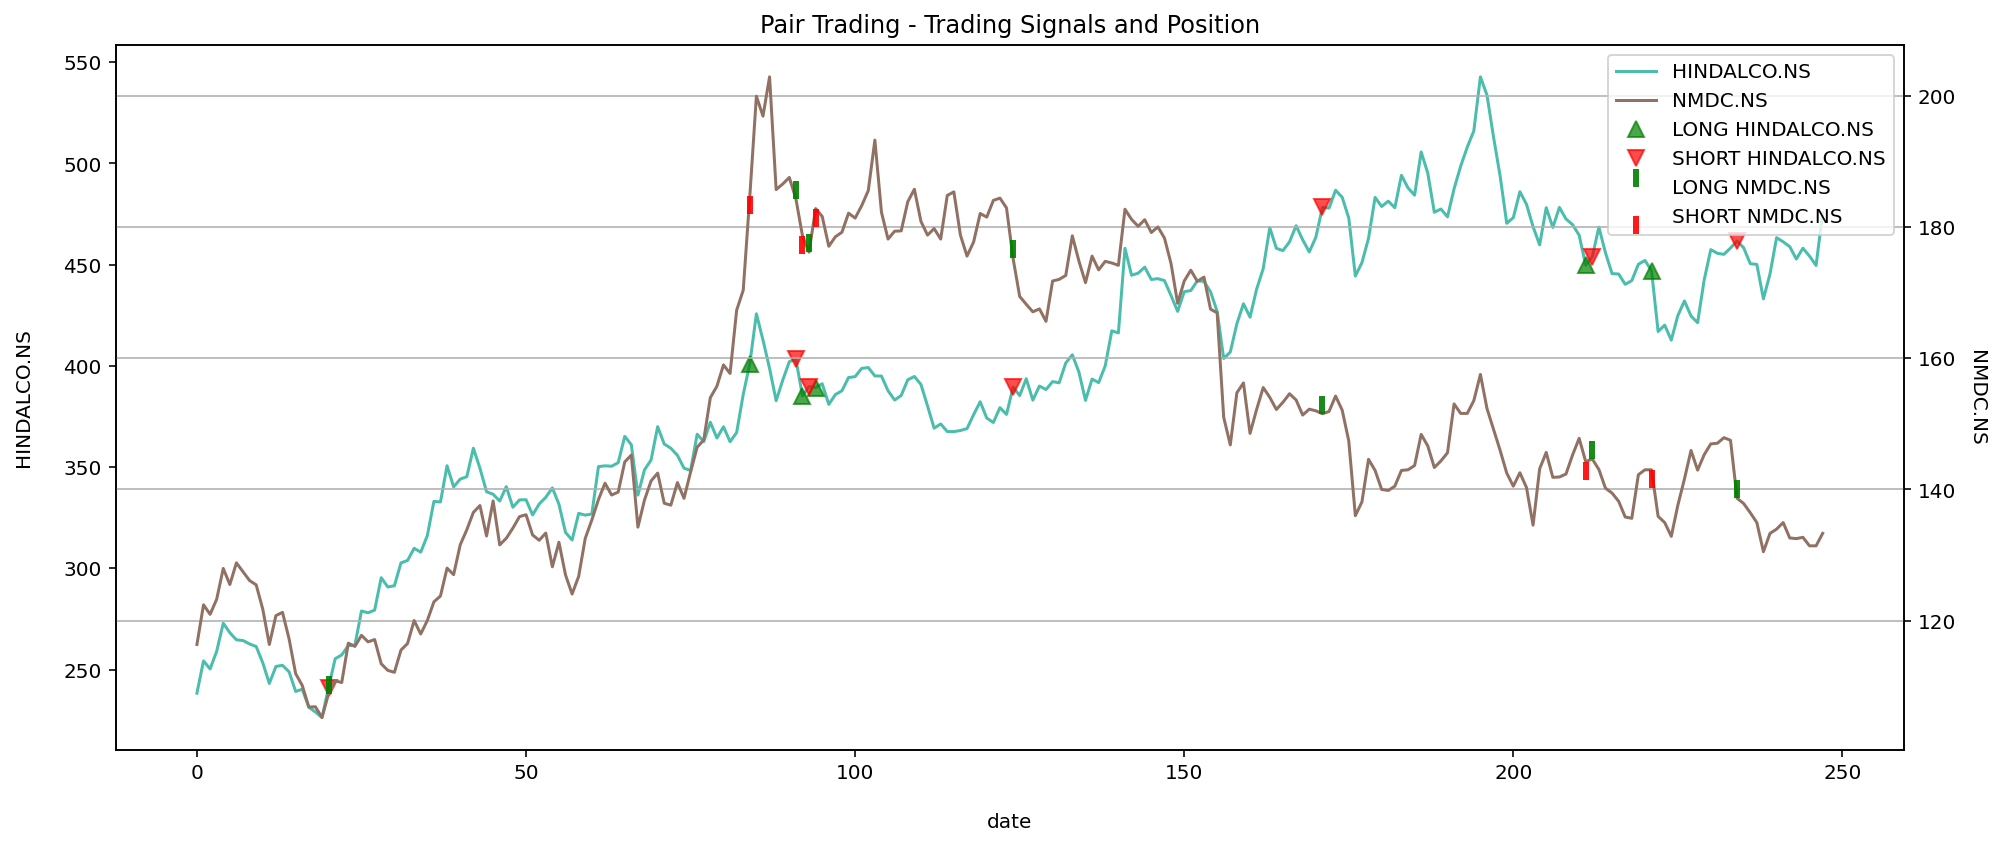

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    238.350006            NaN            NaN            NaN       NaN   
1    254.300003       0.000000  100000.000000  100000.000000       NaN   
2    250.300003       0.000000  100000.000000  100000.000000  0.000000   
3    259.049988       0.000000  100000.000000  100000.000000  0.000000   
4    272.899994       0.000000  100000.000000  100000.000000  0.000000   
243  452.799988 -166630.395510  237153.598878   70523.203367  0.032877   
244  458.149994 -168599.197755  237153.598878   68554.401122 -0.027917   
245  454.250000 -167164.000000  237153.598878   69989.598878  0.020935   
246  449.649994 -165471.197755  237153.598878   71682.401122  0.024186   
247  475.549988 -175002.395510  237153.598878   62151.203367 -0.132964   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   238.350006           NaN            NaN            NaN           NaN   
20  241.149994 -44371.598878  144371.598878  100000.000000 -1.110223e-16   
84  401.100006      0.000000   70569.197755   70569.197755 -3.800055e-02   
91  403.299988 -74207.197755  144776.395510   70569.197755  0.000000e+00   
92  385.200012      0.000000   73899.593266   73899.593266  4.719333e-02   

    positions1  
0          NaN  
20        -1.0  
84         1.0  
91        -1.0  
92         1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    238.350006            NaN            NaN            NaN       NaN   
1    254.300003       0.000000  100000.000000  100000.000000       NaN   
2    250.300003       0.000000  100000.000000  100000.000000  0.000000   
3    259.049988       0.000000  100000.000000  100000.000000  0.000000   
4    272.899994       0.000000  100000.000000  100000.000000  0.000000   
243  452.799988 -166630.395510  237153.598878   70523.203367  0.032877   
244  458.149994 -168599.197755  237153.598878   68554.401122 -0.027917   
245  454.250000 -167164.000000  237153.598878   69989.598878  0.020935   
246  449.649994 -165471.197755  237153.598878   71682.401122  0.024186   
247  475.549988 -175002.395510  237153.598878   62151.203367 -0.132964   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  116.349998            NaN            NaN            NaN   
1           0.0  122.400002       0.000000  100000.000000  100000.000000   
2           0.0  120.949997       0.000000  100000.000000  100000.000000   
3           0.0  123.250000       0.000000  100000.000000  100000.000000   
4           0.0  127.949997       0.000000  100000.000000  100000.000000   
243         0.0  132.500000  130380.000000  -21007.394785  109372.605215   
244         0.0  132.699997  130576.796950  -21007.394785  109569.402165   
245         0.0  131.399994  129297.593998  -21007.394785  108290.199213   
246         0.0  131.399994  129297.593998  -21007.394785  108290.199213   
247         0.0  133.300003  131167.203050  -21007.394785  110159.808266   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243 -0.000899         0.0  
244  0.001799         0.0  
245 -0.011675         0.0  
246  0.000000         0.0  
247  0.017265         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   238.350006           NaN            NaN            NaN           NaN   
20  241.149994 -44371.598878  144371.598878  100000.000000 -1.110223e-16   
84  401.100006      0.000000   70569.197755   70569.197755 -3.800055e-02   
91  403.299988 -74207.197755  144776.395510   70569.197755  0.000000e+00   
92  385.200012      0.000000   73899.593266   73899.593266  4.719333e-02   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  116.349998           NaN            NaN            NaN   
20        -1.0  108.849998  53554.199262   46445.800738  100000.000000   
84         1.0  184.750000      0.000000  137342.800738  137342.800738   
91        -1.0  184.350006  90700.203001   46642.597737  137342.800738   
92         1.0  178.699997      0.000000  134562.996212  134562.996212   

     return2  positions2  
0        NaN         NaN  
20  0.000000         1.0  
84  0.054191        -1.0  
91  0.000000         1.0  
92 -0.020240        -1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

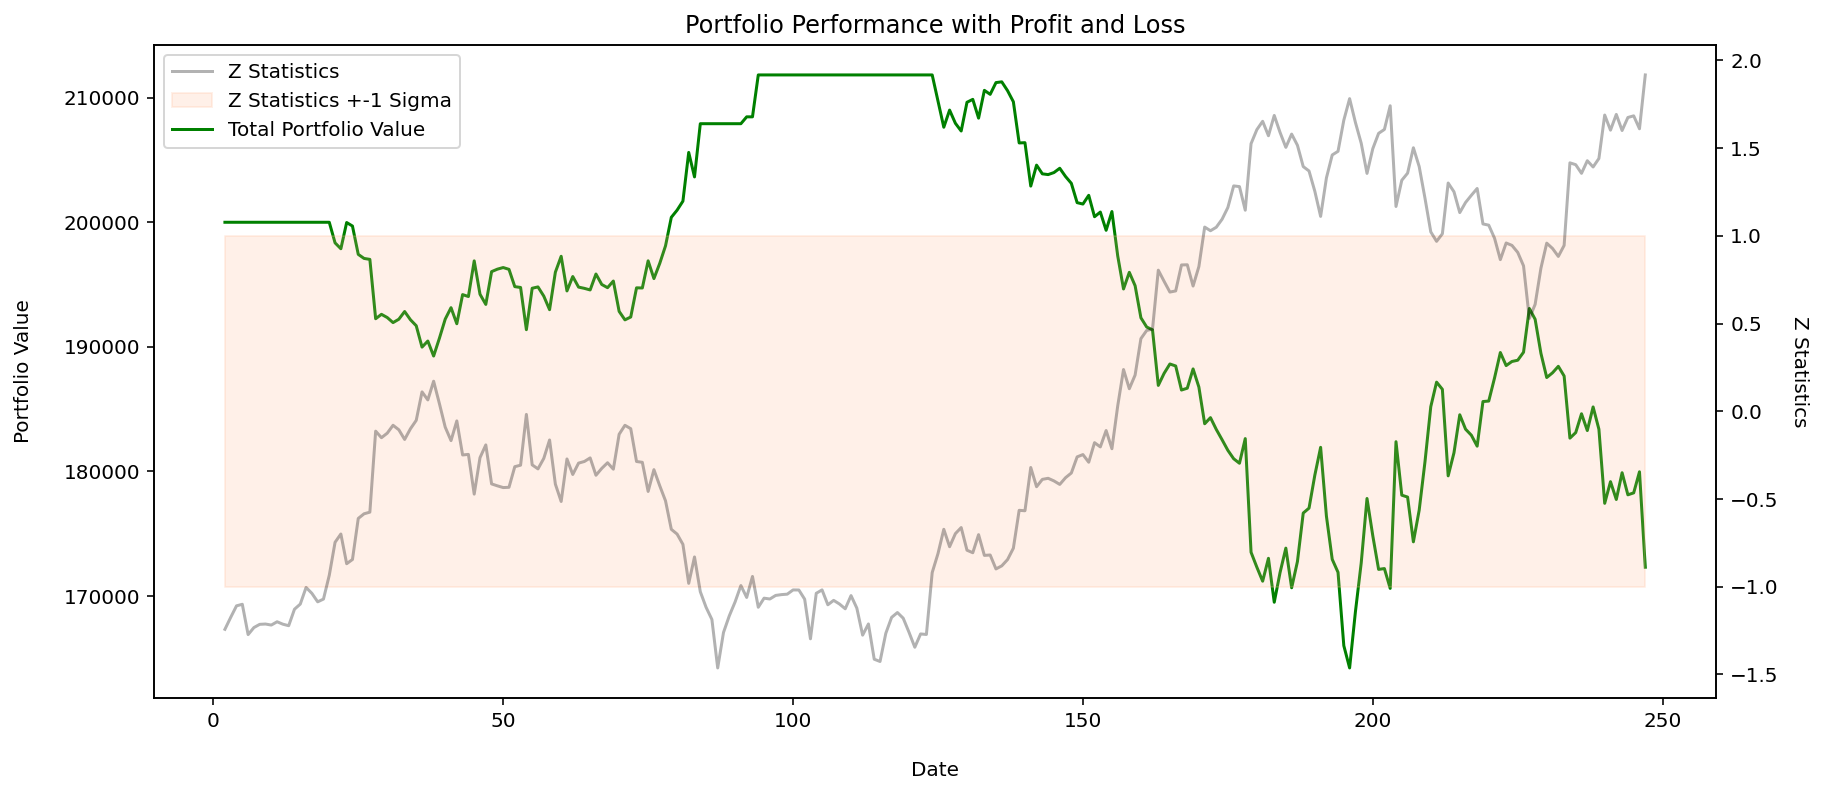

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

172311.01163280001

In [48]:
profit = final_portfolio - 2*initial_capital
profit

-27688.988367199985

In [49]:
roi = (profit/(2*initial_capital))*100
roi

-13.844494183599993

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 124.936%
